# DAT-DEN-03 | Practice

## Affairs Data:

Extramarital affair data used to explain the allocation of an individual’s time among work, time spent with a spouse, and time spent with a paramour. The data is used as an example of regression with censored data.

Number of observations: 6366
Number of variables: 9
Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How religious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-collar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

In [54]:
import statsmodels.api as sm
from sklearn import linear_model
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn import metrics
%pylab inline
import os
import sys
import matplotlib as mpl
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics
from sklearn import grid_search, cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import roc_curve, roc_auc_score

Populating the interactive namespace from numpy and matplotlib


In [55]:
# import affair.csv data as df
df = pd.read_csv(os.path.join('..', 'datasets', 'affair.csv'))

In [56]:
# show few rows
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3,32.0,9.0,3.0,3,17,2,5,0.111111
1,3,27.0,13.0,3.0,1,14,3,4,3.230769
2,4,22.0,2.5,0.0,1,16,3,5,1.400000
3,4,37.0,16.5,4.0,3,16,5,5,0.727273
4,5,27.0,9.0,1.0,1,14,3,4,4.666666


In [57]:
len(df[df['affairs']==0])

4313

## Part A: data exploration

In [58]:
# describe
df.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


In [59]:
df['affair_bool'] = (df.affairs > 0).astype(int)

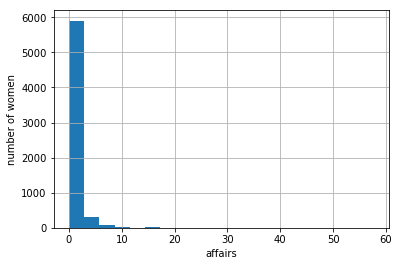

In [60]:
df['affairs'].hist(bins=20)
xlabel('affairs')
ylabel('number of women')

#### Exploring affairs vs marraige ratings : 

In [61]:
rating_vs_target = pd.crosstab(df['occupation'], df['affair_bool'])
rating_vs_target

affair_bool,0,1
occupation,,
1,34,7
2,607,252
3,1818,965
4,1354,480
5,431,309
6,69,40


In [62]:
total_ratings = rating_vs_target.apply(sum)
total_ratings

affair_bool
0    4313
1    2053
dtype: int64

In [63]:
rating_vs_target /= total_ratings
rating_vs_target

affair_bool,0,1
occupation,,
1,0.007883,0.003410
2,0.140737,0.122747
3,0.421516,0.470044
4,0.313935,0.233804
5,0.099930,0.150511
6,0.015998,0.019484


In [64]:
df.corr()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair_bool
rate_marriage,1.000000,-0.111127,-0.128978,-0.129161,0.078794,0.079869,0.039528,0.027745,-0.178068,-0.331776
age,-0.111127,1.000000,0.894082,0.673902,0.136598,0.027960,0.106127,0.162567,-0.089964,0.146519
yrs_married,-0.128978,0.894082,1.000000,0.772806,0.132683,-0.109058,0.041782,0.128135,-0.087737,0.203109
children,-0.129161,0.673902,0.772806,1.000000,0.141845,-0.141918,-0.015068,0.086660,-0.070278,0.159833
religious,0.078794,0.136598,0.132683,0.141845,1.000000,0.032245,0.035746,0.004061,-0.125933,-0.129299
educ,0.079869,0.027960,-0.109058,-0.141918,0.032245,1.000000,0.382286,0.183932,-0.017740,-0.075280
occupation,0.039528,0.106127,0.041782,-0.015068,0.035746,0.382286,1.000000,0.201156,0.004469,0.028981
occupation_husb,0.027745,0.162567,0.128135,0.086660,0.004061,0.183932,0.201156,1.000000,-0.015614,0.017637
affairs,-0.178068,-0.089964,-0.087737,-0.070278,-0.125933,-0.017740,0.004469,-0.015614,1.000000,0.464046
affair_bool,-0.331776,0.146519,0.203109,0.159833,-0.129299,-0.075280,0.028981,0.017637,0.464046,1.000000


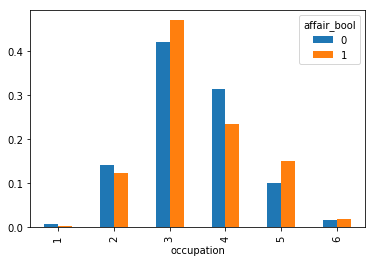

In [65]:
rating_vs_target.plot(kind='bar')

##### Conclusion: Women who rate their marriages higher have lesser number of affairs. Let use a model to verify our claim.

## Show me what you can get? Can you predict who might have an affair or not?

In [66]:
X = df[['age','yrs_married','children']]

In [67]:
X = X.join(pd.get_dummies(df['rate_marriage'],prefix='rate_marriage', drop_first= True))

In [68]:
X.head()

,age,yrs_married,children,rate_marriage_2,rate_marriage_3,rate_marriage_4,rate_marriage_5
0,32.0,9.0,3.0,0,1,0,0
1,27.0,13.0,3.0,0,1,0,0
2,22.0,2.5,0.0,0,0,1,0
3,37.0,16.5,4.0,0,0,1,0
4,27.0,9.0,1.0,0,0,0,1


In [69]:
# occup_dummies = pd.get_dummies()

In [70]:
X= X.join(pd.get_dummies(df['occupation_husb'], prefix='occup_husb',drop_first = True))

In [71]:
X = X.join(pd.get_dummies(df['religious'],prefix='relig',drop_first=True))

In [72]:
X = X.join(pd.get_dummies(df['occupation'],prefix="her_occ",drop_first=True))

In [73]:
X.head()

,age,yrs_married,children,rate_marriage_2,rate_marriage_3,rate_marriage_4,rate_marriage_5,occup_husb_2,occup_husb_3,occup_husb_4,occup_husb_5,occup_husb_6,relig_2,relig_3,relig_4,her_occ_2,her_occ_3,her_occ_4,her_occ_5,her_occ_6
0,32.0,9.0,3.0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
1,27.0,13.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,22.0,2.5,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,37.0,16.5,4.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
4,27.0,9.0,1.0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [74]:
y=df['affair_bool']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42,test_size=.25)


In [76]:
gs1 = grid_search.GridSearchCV(
  estimator = LogisticRegression(),
  param_grid={'C': [10**-i for i in range(-5, 5)],'fit_intercept':[True,False], 'class_weight': ['balanced'],'penalty':['l1']},
  cv=cross_validation.KFold(n=len(X_train),n_folds=10),
    scoring ='roc_auc'
    )

gs1.fit(X_train,y_train)



GridSearchCV(cv=sklearn.cross_validation.KFold(n=4774, n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'class_weight': ['balanced'], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [77]:
gs1.grid_scores_

[mean: 0.73791, std: 0.02008, params: {'penalty': 'l1', 'C': 100000, 'fit_intercept': True, 'class_weight': 'balanced'},
 mean: 0.73800, std: 0.01983, params: {'penalty': 'l1', 'C': 100000, 'fit_intercept': False, 'class_weight': 'balanced'},
 mean: 0.73788, std: 0.02006, params: {'penalty': 'l1', 'C': 10000, 'fit_intercept': True, 'class_weight': 'balanced'},
 mean: 0.73800, std: 0.01983, params: {'penalty': 'l1', 'C': 10000, 'fit_intercept': False, 'class_weight': 'balanced'},
 mean: 0.73788, std: 0.02006, params: {'penalty': 'l1', 'C': 1000, 'fit_intercept': True, 'class_weight': 'balanced'},
 mean: 0.73799, std: 0.01984, params: {'penalty': 'l1', 'C': 1000, 'fit_intercept': False, 'class_weight': 'balanced'},
 mean: 0.73789, std: 0.02007, params: {'penalty': 'l1', 'C': 100, 'fit_intercept': True, 'class_weight': 'balanced'},
 mean: 0.73801, std: 0.01984, params: {'penalty': 'l1', 'C': 100, 'fit_intercept': False, 'class_weight': 'balanced'},
 mean: 0.73776, std: 0.02006, params: {'

In [78]:
gs1.best_estimator_

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [79]:
y_pred = gs1.best_estimator_.predict(X_test)

In [80]:
gs1_confuse = confusion_matrix(y_test, y_pred)
gs1_confuse

array([[727, 328],
       [174, 363]])

In [81]:
roc_auc_score(y_test, y_pred)

0.68253858984881777